# Task 3 : Model Evaluation

In this notebook, we will evaluate the performance of the RF-DETR model on the BDD100K validation split. In task 2.2, we trained RF-DETR Nano on the BDD100k train split for 6 epochs.

In [ ]:
# Please run this cell to install all necessary libraries for this notebook
%pip install -q rfdetr>=1.4.0 supervision roboflow tqdm torch torchvision matplotlib pandas

### I have set my dataset path here, and defined some helper functions for the evaluation.
### If you would like to run the analysis on your system, please adjust the paths accordingly

In [ ]:
from pathlib import Path
import json
from tqdm import tqdm
from collections import defaultdict

DATASET_ROOT = "/home/ghosh/assignment/data/"
VAL_IMAGES_PATH = (
    Path(DATASET_ROOT) / "bdd100k_images_100k" / "bdd100k" / "images" / "100k" / "val"
)
BDD_LABELS_ROOT = Path(DATASET_ROOT) / "bdd100k_labels_release" / "bdd100k" / "labels"

with open(BDD_LABELS_ROOT / "bdd100k_labels_images_val.json", "r") as val_labels_json:
    bdd_json = json.load(val_labels_json)

time_split = defaultdict(lambda: list())

for obj in tqdm(bdd_json, desc="Reading labels for val split"):
    file_name = obj["name"]
    time_of_day = obj["attributes"]["timeofday"]
    time_split[time_of_day].append(file_name)

print("Validation split distribution by time of day:")
for key, value in time_split.items():
    print(f"{len(value)} images taken at {key}")

Reading labels for val split: 100%|██████████| 10000/10000 [00:00<00:00, 1629805.32it/s]

Validation split distribution by time of day:
5258 images taken at daytime
3929 images taken at night
778 images taken at dawn/dusk
35 images taken at undefined


In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path="/home/ghosh/assignment/data/bdd100k_images_100k/bdd100k/images/100k/val",
    annotations_path="/home/ghosh/assignment/data/bdd100k_images_100k/bdd100k/images/100k/val/_annotations.coco.json",
)

In [ ]:
from supervision.metrics import MeanAveragePrecision
from supervision.metrics import MeanAverageRecall
import numpy as np
from supervision.metrics import F1Score
from PIL import Image


def get_targets_and_predictions(model):
    """
    Returns the image targets and model predictions
    """
    targets = []
    predictions = []

    for path, image, annotations in tqdm(ds):
        image = Image.open(path)
        detections = model.predict(image, threshold=0.001)

        targets.append(annotations)
        predictions.append(detections)
    return targets, predictions


def split_targets_and_predictions_by_time(targets, predictions):
    """
    Splits the targets and predictions by time of day
    """
    day_preds, day_targets = [], []
    night_preds, night_targets = [], []
    dawndusk_preds, dawndusk_targets = [], []

    for i, (path, image, annotations) in enumerate(ds):
        # Get the actual filename from the path
        filename = path.split("/")[-1]

        if filename in time_split["daytime"]:
            day_preds.append(predictions[i])
            day_targets.append(targets[i])
        elif filename in time_split["night"]:
            night_preds.append(predictions[i])
            night_targets.append(targets[i])
        elif filename in time_split["dawn/dusk"]:
            dawndusk_preds.append(predictions[i])
            dawndusk_targets.append(targets[i])

    # Make sure lengths match with what we saw before
    # print(f"Day preds length: {len(day_preds)} and Day targets length: {len(day_targets)}")
    # print(f"Night preds length: {len(night_preds)} and night targets length: {len(night_targets)}")
    # print(f"Dawn/Dusk preds length: {len(dawndusk_preds)} and Dawn/Dusk targets length: {len(dawndusk_targets)}")
    return (
        day_preds,
        day_targets,
        night_preds,
        night_targets,
        dawndusk_preds,
        dawndusk_targets,
    )


# Compute mAP and mAR


def compute_map_and_mar(predictions, targets):
    map_metric = MeanAveragePrecision()
    map_result = map_metric.update(predictions, targets).compute()
    print(map_result)
    map_result.plot()

    mar_metric = MeanAverageRecall()
    mar_result = mar_metric.update(predictions, targets)
    print(mar_result)

    class_names = [
        "traffic sign",
        "traffic light",
        "car",
        "rider",
        "motor",
        "person",
        "bus",
        "truck",
        "bike",
        "train",
    ]

    # map_result.ap_per_class[:, 0] gives the first column (IoU 0.50)
    ap_50_per_class = map_result.ap_per_class[:, 0]

    # 3. Print the results for your Per-Class Analysis table
    print(f"{'Class Name':<15} | {'AP @ 50':<10}")
    print("-" * 30)

    for i, class_name in enumerate(class_names):
        # Get the AP value for the current class
        val = ap_50_per_class[i]
        print(f"{class_name:<15} | {val:.4f}")


def compute_global_size_specific_and_class_based_f1_scores(targets, predictions):
    """
    Computes Peak f1-score and associated confidence threshold
    for the entire dataset, size-based classes, and actual categories
    """
    class_names = [
        "traffic sign",
        "traffic light",
        "car",
        "rider",
        "motor",
        "person",
        "bus",
        "truck",
        "bike",
        "train",
    ]

    f1_metric = F1Score()
    conf_thresholds = np.linspace(0.1, 0.9, 9)

    # Storage for Global and Size-specific peaks
    peaks = {"all": 0, "small": 0, "medium": 0, "large": 0, "best_conf": 0}

    # Storage for Per-Class metrics
    class_f1_matrix = np.zeros((len(class_names), len(conf_thresholds)))

    for idx, active_conf in enumerate(tqdm(conf_thresholds)):
        # Filter detections based on current confidence
        filtered_preds = [p[p.confidence > active_conf] for p in predictions]

        # Compute F1 for this threshold
        f1_metric.reset()
        res = f1_metric.update(filtered_preds, targets).compute()

        # Update Global and Size-specific peaks
        if res.f1_50 > peaks["all"]:
            peaks["all"] = res.f1_50
            peaks["best_conf"] = active_conf

        if res.small_objects and res.small_objects.f1_50 > peaks["small"]:
            peaks["small"] = res.small_objects.f1_50

        if res.medium_objects and res.medium_objects.f1_50 > peaks["medium"]:
            peaks["medium"] = res.medium_objects.f1_50

        if res.large_objects and res.large_objects.f1_50 > peaks["large"]:
            peaks["large"] = res.large_objects.f1_50

        # Store Per-Class F1 @ IoU 0.50
        class_f1_matrix[:, idx] = res.f1_per_class[:, 0]

    print("GLOBAL & SIZE-SPECIFIC PEAKS")
    print(f"Global Peak F1: {peaks['all']:.4f} at {peaks['best_conf']:.1f} confidence")
    print(f"Small Peak F1:  {peaks['small']:.4f}")
    print(f"Medium Peak F1: {peaks['medium']:.4f}")
    print(f"Large Peak F1:  {peaks['large']:.4f}")

    print("\nPER-CLASS PEAK F1-SCORES")
    print(f"{'Class Name':<15} | {'Peak F1':<10} | {'Best Conf'}")
    print("-" * 40)

    per_class_peaks = {}
    for i, name in enumerate(class_names):
        peak_val = np.max(class_f1_matrix[i, :])
        best_conf_idx = np.argmax(class_f1_matrix[i, :])
        best_conf = conf_thresholds[best_conf_idx]
        per_class_peaks[name] = (peak_val, best_conf)
        print(f"{name:<15} | {peak_val:<10.4f} | {best_conf:.2f}")

We'll generate the metrics by calling the helper functions we defined above

In [ ]:
from rfdetr import RFDETRNano

trained_model = RFDETRNano(
    pretrain_weights="/home/ghosh/assignment/trained_models/rfdetr_manual_6.pth"
)  # Since we trained for 6 epochs
trained_model.optimize_for_inference()

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.


Loading pretrain weights


Reinitializing detection head with 11 classes


100%|██████████| 10000/10000 [03:19<00:00, 50.11it/s]


Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.230
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.429
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.209
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.053
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.254
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.553


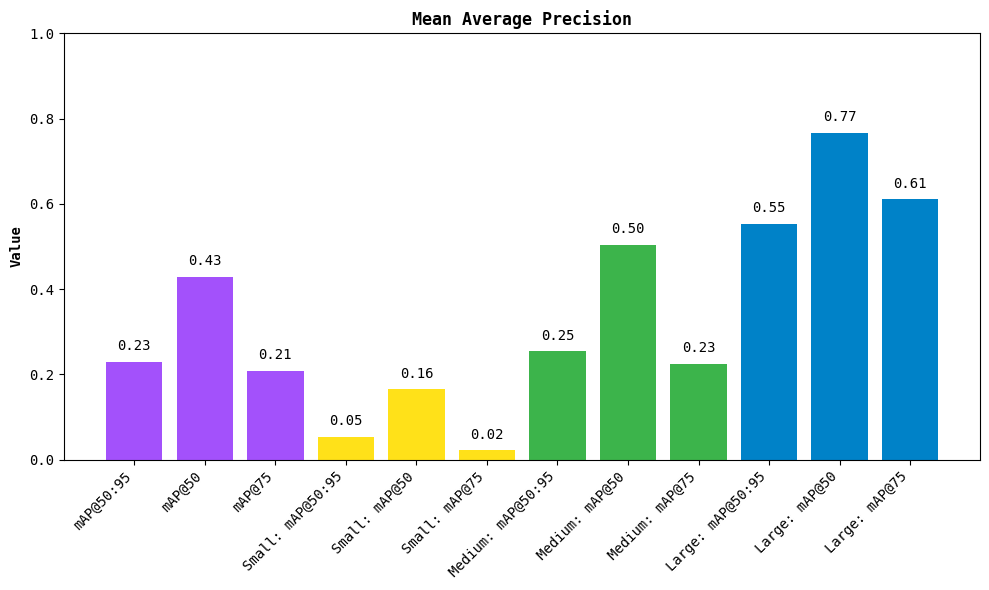

Class Name      | AP @ 50   
------------------------------
traffic sign    | 0.5256
traffic light   | 0.4728
car             | 0.6802
rider           | 0.3436
motor           | 0.3621
person          | 0.4404
bus             | 0.5510
truck           | 0.5447
bike            | 0.3525
train           | 0.0124


100%|██████████| 9/9 [02:11<00:00, 14.56s/it]


GLOBAL & SIZE-SPECIFIC PEAKS
Global Peak F1: 0.6081 at 0.4 confidence
Small Peak F1:  0.3972
Medium Peak F1: 0.6973
Large Peak F1:  0.9073

PER-CLASS PEAK F1-SCORES
Class Name      | Peak F1    | Best Conf
----------------------------------------
traffic sign    | 0.5659     | 0.30
traffic light   | 0.5413     | 0.40
car             | 0.6686     | 0.40
rider           | 0.4227     | 0.30
motor           | 0.4219     | 0.30
person          | 0.4738     | 0.30
bus             | 0.5621     | 0.40
truck           | 0.5513     | 0.40
bike            | 0.4017     | 0.30
train           | 0.0606     | 0.10
Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.236
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.434
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.218
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.061
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.273
Ave

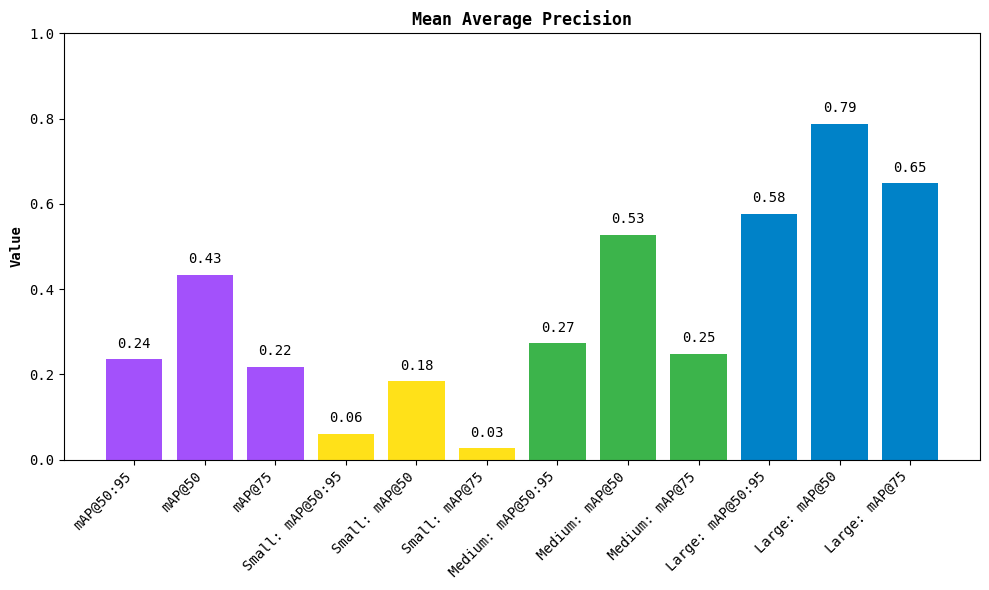

Class Name      | AP @ 50   
------------------------------
traffic sign    | 0.4974
traffic light   | 0.4694
car             | 0.6925
rider           | 0.3608
motor           | 0.3932
person          | 0.4543
bus             | 0.5616
truck           | 0.5467
bike            | 0.3367
train           | 0.0262


100%|██████████| 9/9 [01:12<00:00,  8.06s/it]


GLOBAL & SIZE-SPECIFIC PEAKS
Global Peak F1: 0.6094 at 0.4 confidence
Small Peak F1:  0.3827
Medium Peak F1: 0.7155
Large Peak F1:  0.9130

PER-CLASS PEAK F1-SCORES
Class Name      | Peak F1    | Best Conf
----------------------------------------
traffic sign    | 0.5476     | 0.30
traffic light   | 0.5303     | 0.40
car             | 0.6824     | 0.40
rider           | 0.4342     | 0.30
motor           | 0.4444     | 0.30
person          | 0.4847     | 0.30
bus             | 0.5736     | 0.40
truck           | 0.5545     | 0.40
bike            | 0.3893     | 0.30
train           | 0.0833     | 0.10
Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.217
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.413
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.194
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.051
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.219
Ave

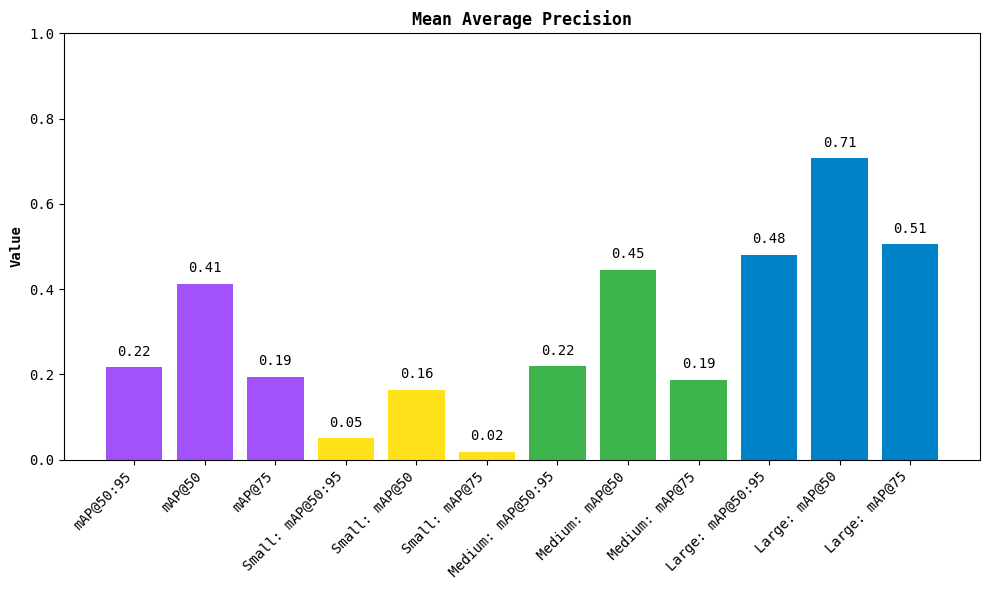

Class Name      | AP @ 50   
------------------------------
traffic sign    | 0.5697
traffic light   | 0.4754
car             | 0.6588
rider           | 0.3084
motor           | 0.3173
person          | 0.3946
bus             | 0.4892
truck           | 0.5264
bike            | 0.3864
train           | 0.0043


100%|██████████| 9/9 [00:46<00:00,  5.21s/it]


GLOBAL & SIZE-SPECIFIC PEAKS
Global Peak F1: 0.6043 at 0.4 confidence
Small Peak F1:  0.4209
Medium Peak F1: 0.6579
Large Peak F1:  0.8964

PER-CLASS PEAK F1-SCORES
Class Name      | Peak F1    | Best Conf
----------------------------------------
traffic sign    | 0.5966     | 0.40
traffic light   | 0.5573     | 0.40
car             | 0.6437     | 0.40
rider           | 0.3979     | 0.30
motor           | 0.3824     | 0.40
person          | 0.4365     | 0.30
bus             | 0.4991     | 0.30
truck           | 0.5347     | 0.30
bike            | 0.4232     | 0.30
train           | 0.0000     | 0.10
Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.224
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.419
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.201
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.057
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.302
Ave

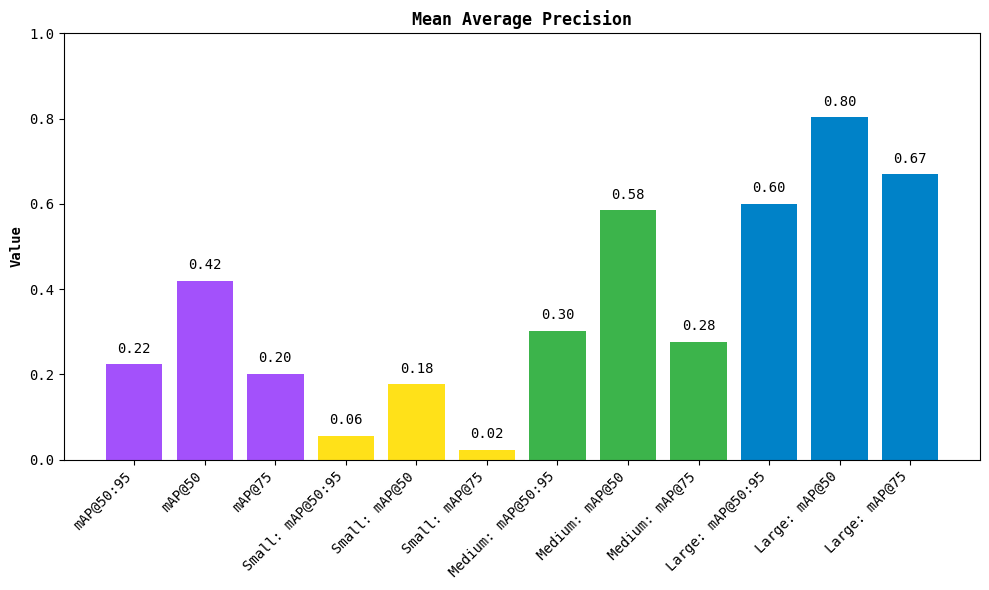

Class Name      | AP @ 50   
------------------------------
traffic sign    | 0.5194
traffic light   | 0.4604
car             | 0.6791
rider           | 0.2917
motor           | 0.1949
person          | 0.4382
bus             | 0.5941
truck           | 0.5675
bike            | 0.4491
train           | 0.0000


100%|██████████| 9/9 [00:10<00:00,  1.16s/it]

GLOBAL & SIZE-SPECIFIC PEAKS
Global Peak F1: 0.6116 at 0.4 confidence
Small Peak F1:  0.3903
Medium Peak F1: 0.7255
Large Peak F1:  0.9187

PER-CLASS PEAK F1-SCORES
Class Name      | Peak F1    | Best Conf
----------------------------------------
traffic sign    | 0.5618     | 0.30
traffic light   | 0.5235     | 0.30
car             | 0.6778     | 0.40
rider           | 0.3934     | 0.40
motor           | 0.3000     | 0.30
person          | 0.4705     | 0.30
bus             | 0.5963     | 0.40
truck           | 0.5660     | 0.30
bike            | 0.4587     | 0.30
train           | 0.0000     | 0.10


In [46]:
# And we'll call the helper functions again, but this time with the new model
targets, predictions = get_targets_and_predictions(trained_model)
day_preds, day_targets, night_preds, night_targets, dawndusk_preds, dawndusk_targets = (
    split_targets_and_predictions_by_time(targets, predictions)
)

# Whole Dataset
compute_map_and_mar(predictions, targets)
compute_global_size_specific_and_class_based_f1_scores(targets, predictions)

# Daytime
compute_map_and_mar(day_preds, day_targets)
compute_global_size_specific_and_class_based_f1_scores(day_targets, day_preds)

# Nighttime
compute_map_and_mar(night_preds, night_targets)
compute_global_size_specific_and_class_based_f1_scores(night_targets, night_preds)

# Dawn/Dusk
compute_map_and_mar(dawndusk_preds, dawndusk_targets)
compute_global_size_specific_and_class_based_f1_scores(dawndusk_targets, dawndusk_preds)

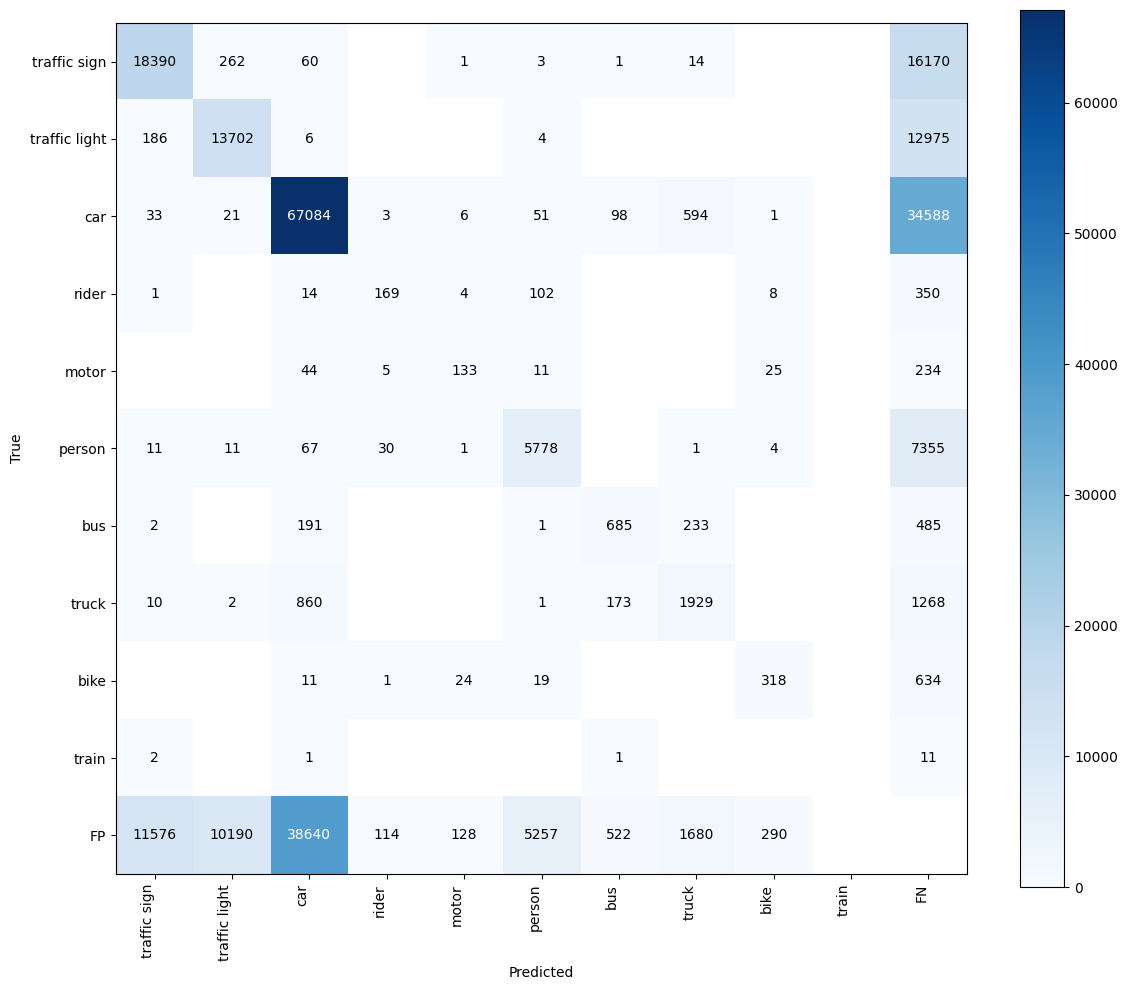

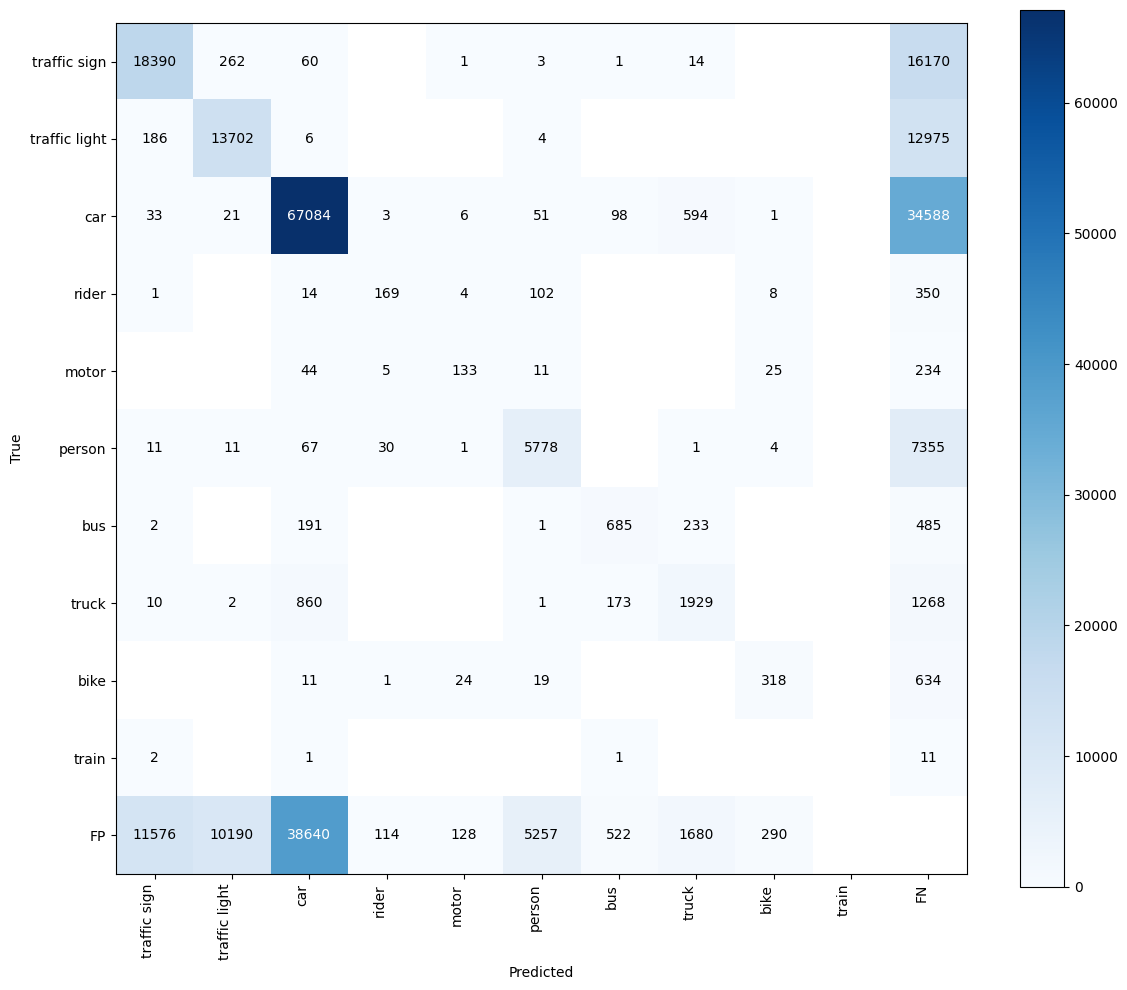

In [47]:
# Now that most of the metrics have been computed, let's visualize the confusion matrix
# Initialize Confusion Matrix using your dataset classes
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions, targets=targets, classes=ds.classes
)

# Plot and save
confusion_matrix.plot(save_path="confusion_matrix.png")

100%|██████████| 10000/10000 [03:34<00:00, 46.57it/s]


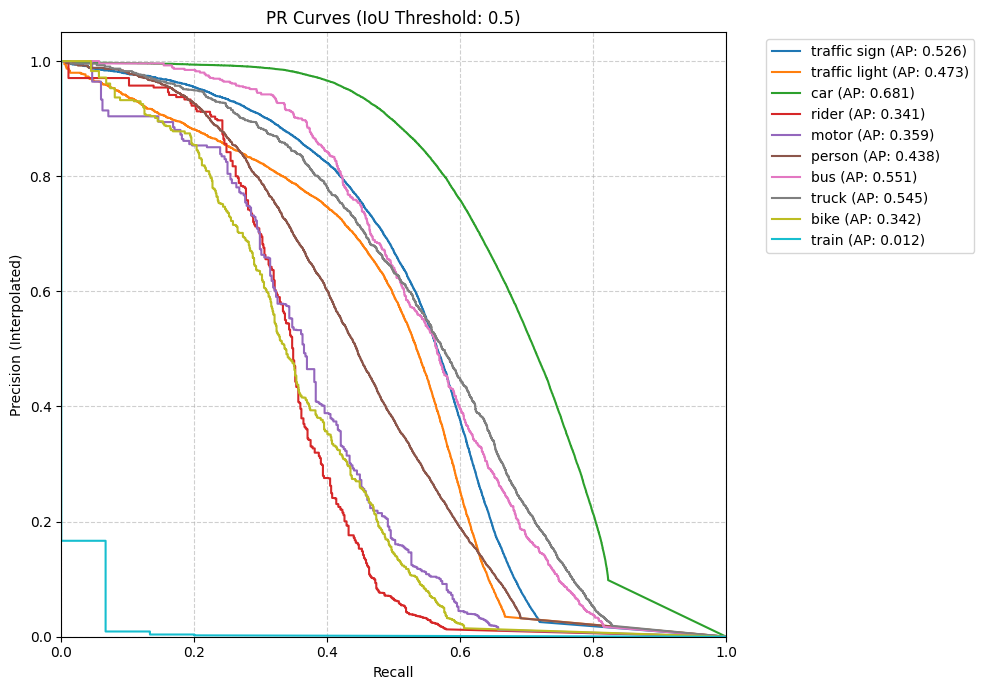

In [49]:
# Our last image for the quantitative evaluation is a PR-Curve
# I have to compute this by hand since the supervision library doesn't provide the functionality to generate it

import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm


def box_iou_matrix(boxes1, boxes2):
    if len(boxes2) == 0:
        return np.zeros((len(boxes1), 0))

    b1 = boxes1[:, None, :]
    b2 = boxes2[None, :, :]

    inter_x1 = np.maximum(b1[..., 0], b2[..., 0])
    inter_y1 = np.maximum(b1[..., 1], b2[..., 1])
    inter_x2 = np.minimum(b1[..., 2], b2[..., 2])
    inter_y2 = np.minimum(b1[..., 3], b2[..., 3])

    inter = np.maximum(0, inter_x2 - inter_x1) * np.maximum(0, inter_y2 - inter_y1)

    area1 = (b1[..., 2] - b1[..., 0]) * (b1[..., 3] - b1[..., 1])
    area2 = (b2[..., 2] - b2[..., 0]) * (b2[..., 3] - b2[..., 1])

    union = area1 + area2 - inter
    return inter / (union + 1e-6)


records = defaultdict(list)  # class -> [(score, is_tp)]
gt_count = defaultdict(int)
iou_thr = 0.5

CATEGORIES = {
    0: "traffic sign",
    1: "traffic light",
    2: "car",
    3: "rider",
    4: "motor",
    5: "person",
    6: "bus",
    7: "truck",
    8: "bike",
    9: "train",
}

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = trained_model.predict(image, threshold=0.0)

    # CRITICAL: Iterate over all classes present in BOTH GT and Detections
    # to ensure False Positives are captured correctly.
    present_classes = np.unique(
        np.concatenate([annotations.class_id, detections.class_id])
    )

    for c in present_classes:
        gt_mask = annotations.class_id == c
        pred_mask = detections.class_id == c

        gt_boxes = annotations.xyxy[gt_mask]
        pred_boxes = detections.xyxy[pred_mask]
        scores = detections.confidence[pred_mask]

        gt_count[c] += len(gt_boxes)

        if len(pred_boxes) == 0:
            continue

        # Sort predictions by confidence per image
        order = np.argsort(-scores)
        pred_boxes = pred_boxes[order]
        scores = scores[order]

        matched = np.zeros(len(gt_boxes))
        ious = box_iou_matrix(pred_boxes, gt_boxes)

        for i in range(len(pred_boxes)):
            # If no GT exists for this class in this image, every prediction is an FP
            if len(gt_boxes) == 0:
                records[c].append((scores[i], 0))
                continue

            best_iou_idx = np.argmax(ious[i])
            if ious[i, best_iou_idx] >= iou_thr and matched[best_iou_idx] == 0:
                matched[best_iou_idx] = 1
                records[c].append((scores[i], 1))  # True Positive
            else:
                records[c].append((scores[i], 0))  # False Positive

plt.figure(figsize=(10, 7))

for c in sorted(records.keys()):
    recs = records[c]
    if not recs:
        continue

    # Sort globally by score
    recs.sort(key=lambda x: x[0], reverse=True)

    tp = np.array([r[1] for r in recs])
    fp = 1 - tp

    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)

    recall = tp_cum / (gt_count[c] + 1e-6)
    precision = tp_cum / (tp_cum + fp_cum + 1e-6)

    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([1.0], precision, [0.0]))

    mpre = np.maximum.accumulate(mpre[::-1])[::-1]

    indices = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[indices + 1] - mrec[indices]) * mpre[indices + 1])

    plt.plot(mrec, mpre, label=f"{CATEGORIES.get(c, f'Class {c}')} (AP: {ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision (Interpolated)")
plt.title(f"PR Curves (IoU Threshold: {iou_thr})")
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("pr_curves_final.png", dpi=300)
plt.show()

## Finally, we visualize some images for the qualitative analysis

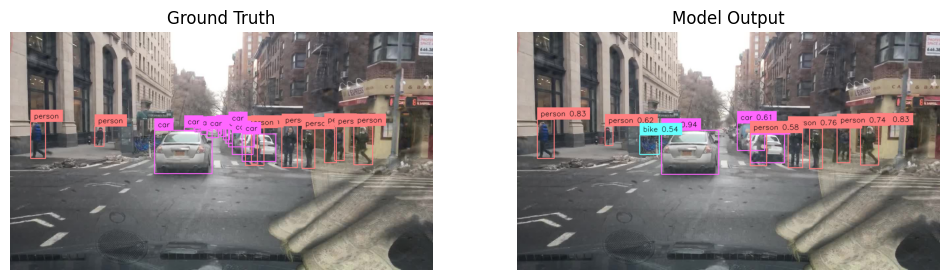

In [58]:
import supervision as sv
from PIL import Image

path, image, annotations = ds[17]
image = Image.open(path)

detections = trained_model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex(
    [
        "#ffff00",
        "#ff9b00",
        "#ff66ff",
        "#3399ff",
        "#ff66b2",
        "#ff8080",
        "#b266ff",
        "#9999ff",
        "#66ffff",
        "#33ff99",
        "#66ff66",
        "#99ff00",
    ]
)

bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color, text_color=sv.Color.BLACK, text_scale=text_scale
)

annotations_labels = [f"{ds.classes[class_id]}" for class_id in annotations.class_id]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(
    annotation_image, annotations, annotations_labels
)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(
    detections_image, detections, detections_labels
)

sv.plot_images_grid(
    images=[annotation_image, detections_image],
    grid_size=(1, 2),
    titles=["Ground Truth", "Model Output"],
)

Found image at index 4279: /home/ghosh/assignment/data/bdd100k_images_100k/bdd100k/images/100k/val/bcaf73c1-f32b1d31.jpg


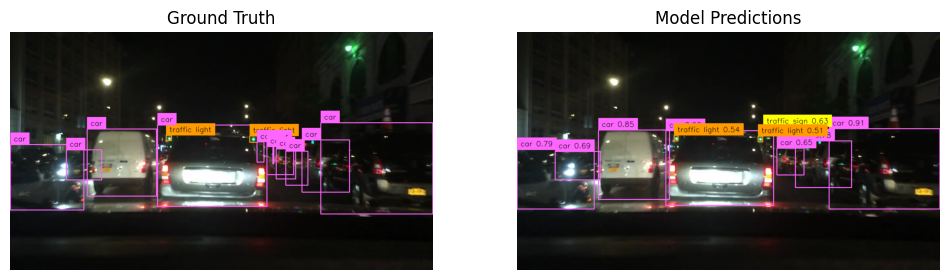

In [ ]:
import supervision as sv
from PIL import Image

target_filename = "/home/ghosh/assignment/data/bdd100k_images_100k/bdd100k/images/100k/val/bcaf73c1-f32b1d31.jpg"

found_data = None
for i in range(len(ds)):
    # Assuming ds[i] returns (path, image, annotations)
    # Adjust index [0] if your dataset returns a different structure
    entry_path = str(ds[i][0])

    if target_filename in entry_path:
        path, image, annotations = ds[i]
        found_data = (path, image, annotations)
        print(f"Found image at index {i}: {path}")
        break

if not found_data:
    print(f"Error: File '{target_filename}' not found in the dataset.")
else:
    if not isinstance(image, Image.Image):
        image = Image.open(path).convert("RGB")
    else:
        image = image.convert("RGB")

    detections = trained_model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    # Custom vibrant color palette
    color = sv.ColorPalette.from_hex(
        [
            "#ffff00",
            "#ff9b00",
            "#ff66ff",
            "#3399ff",
            "#ff66b2",
            "#ff8080",
            "#b266ff",
            "#9999ff",
            "#66ffff",
            "#33ff99",
            "#66ff66",
            "#99ff00",
        ]
    )

    # Initialize Annotators
    bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        color=color, text_color=sv.Color.BLACK, text_scale=text_scale
    )

    # Ground Truth Labels
    annotations_labels = [
        f"{ds.classes[class_id]}" for class_id in annotations.class_id
    ]

    # Model Prediction Labels (Include Confidence)
    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence in zip(detections.class_id, detections.confidence)
    ]

    gt_image = image.copy()
    gt_image = bbox_annotator.annotate(scene=gt_image, detections=annotations)
    gt_image = label_annotator.annotate(
        scene=gt_image, detections=annotations, labels=annotations_labels
    )

    pred_image = image.copy()
    pred_image = bbox_annotator.annotate(scene=pred_image, detections=detections)
    pred_image = label_annotator.annotate(
        scene=pred_image, detections=detections, labels=detections_labels
    )

    sv.plot_images_grid(
        images=[gt_image, pred_image],
        grid_size=(1, 2),
        titles=["Ground Truth", "Model Predictions"],
    )

## That brings us to the end of the end of the evaluation notebook. While I have not discussed the performance of the model here, please refer to the readme of my github repo or run the app for the precomputed results. Thank you!